# **Importing Modules**

In [ ]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time
from google.colab import drive

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


import tensorflow as tf
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt


from shutil import copyfile
import shutil  
from keras import backend as K
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import os
from os import path
from os import walk
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,GlobalMaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import layers
import keras
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import json
import pandas as pd
%matplotlib inline
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import cv2
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.layers import *
#from keras_app.keras_applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import MobileNetV2
import random
import tensorflow as tf
import numpy as np
from keras.models import Model
from keras.models import model_from_json
import matplotlib.pyplot as plt
import os

## **Loading Detection and Recognition Models**

In [ ]:
#Provide ocrocr12345@gmail.com Account
drive.mount('/content/train')

Mounted at /content/train


In [ ]:
!unzip "/content/train/My Drive/charDetect-I.zip"
!unzip "/content/train/My Drive/crnn-I.zip"

Archive:  /content/train/My Drive/charDetect-I.zip
  inflating: charDetect-I.h5         
Archive:  /content/train/My Drive/crnn-I.zip
  inflating: crnn-I.h5               


In [ ]:
drive.flush_and_unmount()

# **Text Detection Model**

In [ ]:
import numpy as np
import os
import tensorflow as tf
from scipy.io import loadmat
import cv2
import matplotlib.pyplot as plt





def decode_to_boxes(output , ht , wd):
    #output : (x,x,1,5)
    #x,y,h,w

    img_ht = ht
    img_wd = wd
    threshold = 0.5
    grid_h,grid_w = output.shape[:2]
    final_boxes = []
    scores = []

    for i in range(grid_h):
        for j in range(grid_w):
            if output[i,j,0,0] > threshold:

                temp = output[i,j,0,1:5]
                
                x_unit = ((j + (temp[0]))/grid_w)*img_wd
                y_unit = ((i + (temp[1]))/grid_h)*img_ht
                width = temp[2]*img_wd*1.3
                height = temp[3]*img_ht*1.3
                
                final_boxes.append([x_unit - width/2,y_unit - height/2 ,x_unit + width/2,y_unit + height/2])
                scores.append(output[i,j,0,0])
    
    return final_boxes,scores



def iou(box1,box2):

    x1 = max(box1[0],box2[0])
    x2 = min(box1[2],box2[2])
    y1 = max(box1[1] ,box2[1])
    y2 = min(box1[3],box2[3])
    
    inter = (x2 - x1)*(y2 - y1)
    
    area1 = (box1[2] - box1[0])*(box1[3] - box1[1])
    area2 = (box2[2] - box2[0])*(box2[3] - box2[1])
    fin_area = area1 + area2 - inter
        
    iou = inter/fin_area
    
    return iou



def non_max(boxes , scores , iou_num):

    scores_sort = scores.argsort().tolist()
    keep = []
    
    while(len(scores_sort)):
        
        index = scores_sort.pop()
        keep.append(index)
        
        if(len(scores_sort) == 0):
            break
    
        iou_res = []
    
        for i in scores_sort:
            iou_res.append(iou(boxes[index] , boxes[i]))
        
        iou_res = np.array(iou_res)
        filtered_indexes = set((iou_res > iou_num).nonzero()[0])

        scores_sort = [v for (i,v) in enumerate(scores_sort) if i not in filtered_indexes]
    
    final = []
    
    for i in keep:
        final.append(boxes[i])
    
    return final


def decode(output , ht , wd , iou):
    
    
    boxes , scores = decode_to_boxes(output ,ht ,wd)
    
    
    boxes = non_max(boxes,np.array(scores) , iou)
    
    
    return boxes
    


In [ ]:
inp = (512, 512, 3)
inp_tensor = Input(inp)
model = MobileNetV2( input_tensor= inp_tensor , include_top=False, weights='imagenet')
last_layer = model.output
conv = Conv2D(512,(3,3) , activation='relu' , padding='same')(last_layer)
conv = Dropout(0.4)(conv)
bn = BatchNormalization()(conv)
lr = LeakyReLU(alpha=0.1)(bn)
conv = Conv2D(128,(3,3) , activation='relu' , padding='same')(lr)
conv = Dropout(0.4)(conv)
bn = BatchNormalization()(conv)
lr = LeakyReLU(alpha=0.1)(bn)
conv = Conv2D(5,(3,3) , activation='relu' , padding='same')(lr)
final = Reshape((16,16,1,5))(conv)
charDetect = Model(inp_tensor,final)
    

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
charDetect.load_weights("/content/charDetect-I.h5")

In [ ]:
def predict_func(model , inp , iou , name):

    ans = model.predict(inp)
    
    #np.save('Results/ans.npy',ans)
    boxes = decode(ans[0] , 512 , 512 , iou)
    #print(ans[0])
    #print(boxes)
    img = ((inp + 1)/2)
    img = img[0]
    croppedImages = []
    print(boxes)
    rectangles = []


    for i in boxes:
        i = [int(x) for x in i]
        crop_img = img[i[1]-5:i[3]+5, i[0]-10:i[2]+10]
        croppedImages.append(crop_img)
        plt.figure()
        plt.imshow(crop_img)
        plt.show()
        rectangles.append(((i[0] ,i[1]) , (i[2] , i[3])))
        #img = cv2.rectangle(img , (i[0] ,i[1]) , (i[2] , i[3]) , color = (255,0,0) , thickness = 3)
    #plt.imshow(img)
    #plt.show()
    return croppedImages,rectangles
    

## **Text Recognition Model**

In [ ]:
char_list = string.ascii_letters+string.digits

In [ ]:
inputs = Input(shape=(32,128,1))
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
batch_norm_5 = BatchNormalization()(conv_5)
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)
recognizeModel = Model(inputs, outputs)

In [ ]:
recognizeModel.load_weights("/content/crnn-I.h5")

## **Prediction**

In [ ]:
def showImg(fname):
  img = cv2.imread(os.path.join("/content/", fname))
  #print(img.shape)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
  plt.figure()
  plt.imshow(img)
  
def recognizeText(fname):
  img = cv2.imread(fname)
  showImg(fname)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  w,h = img.shape
  print(img.shape)
  if (w>32 and h>128):
    img = cv2.resize(img,(128,32))
    print(1)
  if (w<32 and h>128):
    #add_zeros = np.ones((32-w, h))*255
    #img = np.concatenate((img, add_zeros))
    #img = cv2.resize(img,(128,32))
    img = cv2.resize(img,(128,32))
    print(2)
  if (w>32 and h<128):
    #add_zeros = np.ones((32, 128-h))*255
    #img = np.concatenate((img, add_zeros), axis=1)
    #img = cv2.resize(img, (32,128))
    #add_zeros = np.ones((32, 128))*255
    #img = np.concatenate((img, add_zeros), axis=1)
    img = cv2.resize(img,(128,32))
    print(3)
  if w < 32 and h<128:
    #add_zeros = np.ones((32-w, h))*255
    #img = np.concatenate((img, add_zeros))
    #add_zeros = np.ones((32, 128-h))*255
    #img = np.concatenate((img, add_zeros), axis=1)
    img = cv2.resize(img,(128,32))
    print(4)
  img = np.expand_dims(img , axis = 2) 
  img = np.expand_dims(img , axis = 0)     
  img = img/255.
  print(img.shape)
  prediction = recognizeModel.predict([img]) 
  out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
  s = ""
  for p in out[0]:  
        if int(p) != -1:
            s = s + char_list[int(p)]
  print(s) 
  return s
    

        

In [ ]:
def showRecogImg(fname, rectangles, recognizedText):
  img = cv2.imread(fname)
  w = img.shape[0]
  h = img.shape[1]
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  i = 0 
  for rect in rectangles:
    img = cv2.rectangle(img , (rect[0][0]*h//512 ,rect[0][1]*w//512) , (rect[1][0]*h//512,rect[1][1]*w//512), color = (255,0,0) , thickness = 3)
    font = cv2.FONT_HERSHEY_SIMPLEX 
    org = (rect[0][0]*h//512 ,rect[0][1]*w//512 - 20) 
    if(w+h>512+512):
      fontScale = (w+h)//(512+512)
      org = (rect[0][0]*h//512 ,rect[0][1]*w//512 - 20) 
      thickness = fontScale
    else:
      fontScale = 0.5
      org = (rect[0][0]*h//512 ,rect[0][1]*w//512 - 5) 
      thickness = 1
    color = (255, 0, 0) 
    
    img = cv2.putText(img, recognizedText[i], org, font,  
                   fontScale, color, thickness, cv2.LINE_AA)
    print(recognizedText[i])
    i = i+ 1 
  plt.grid(b=None)
  plt.imshow(img)
  plt.show
def saveImg(img):
  #print(img.shape)
  img_float32 = np.float32(img)
  img = cv2.cvtColor(img_float32, cv2.COLOR_BGR2RGB)
  img = img*255
  cv2.imwrite("recognize11.jpg",img) 

(300, 400, 3)
(512, 512, 3)
[[234.3748893737793, 317.6874114990234, 483.40842056274414, 374.1426628112793], [213.12747449874877, 257.46432666778566, 310.84378080368043, 303.51259059906005], [303.2033630371094, 184.58929138183595, 443.1028999328613, 240.23384780883788], [47.32627086639404, 316.7585260391235, 225.6865446090698, 375.0087507247925], [82.19113082885742, 183.50051326751708, 273.2271583557129, 241.7547052383423]]


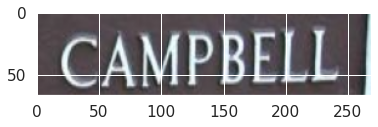

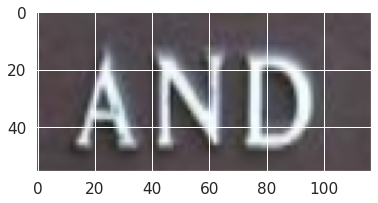

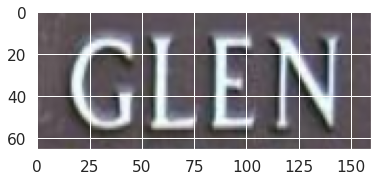

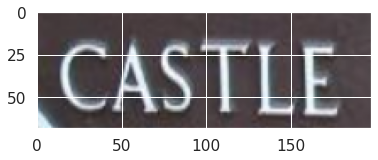

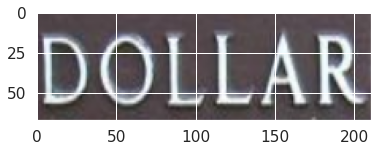

In [ ]:
#img = cv2.imread("/content/Train/"+trainFiles[2])
path = "/content/detect3.jpg"
img = cv2.imread(path)
print(img.shape)
img = cv2.resize(img, (512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
print(img.shape)
img = (img - 127.5)/127.5
croppedImages,rectangles = predict_func(charDetect, np.expand_dims(img,axis= 0), 0.5, "test")

(67, 269)
1
(1, 32, 128, 1)
CAMPBELL
(56, 117)
3
(1, 32, 128, 1)
ANDs
(66, 160)
1
(1, 32, 128, 1)
GLEN
(69, 198)
1
(1, 32, 128, 1)
CaSTLE
(68, 211)
1
(1, 32, 128, 1)
DOLLAR


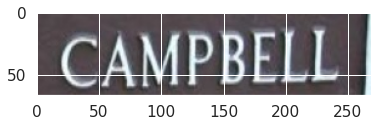

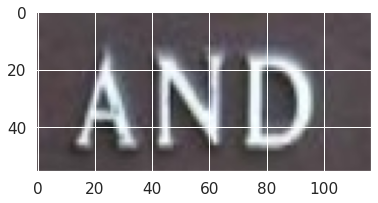

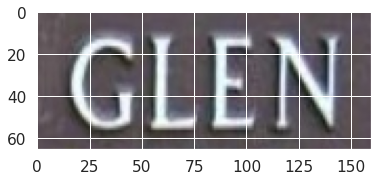

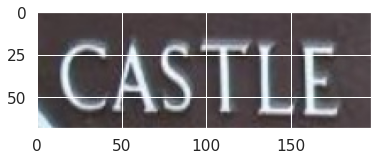

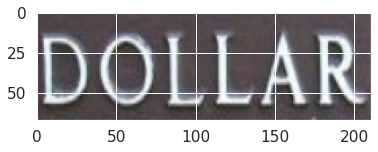

In [ ]:
recognizedText = []
for img in croppedImages:
  saveImg(img)
  recognizedText.append(recognizeText("/content/recognize11.jpg"))

CAMPBELL
ANDs
GLEN
CaSTLE
DOLLAR


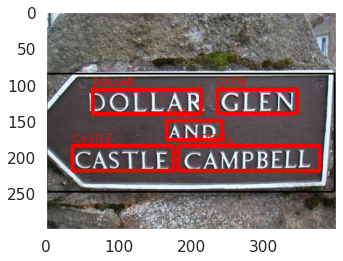

In [ ]:
showRecogImg(path, rectangles, recognizedText)

(300, 600, 3)
(512, 512, 3)
[[170.4593635559082, 170.9741594314575, 375.43432846069334, 236.15099124908448], [47.5034812927246, 166.59580993652344, 177.73589477539065, 256.4256591796875]]


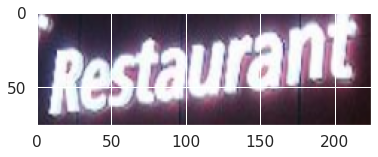

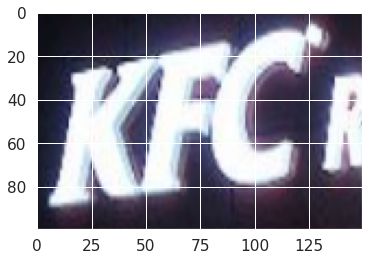

In [ ]:
#img = cv2.imread("/content/Train/"+trainFiles[2])
path = "/content/detect5.jpg"
img = cv2.imread(path)
print(img.shape)
img = cv2.resize(img, (512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
print(img.shape)
img = (img - 127.5)/127.5
croppedImages,rectangles = predict_func(charDetect, np.expand_dims(img,axis= 0), 0.5, "test")

(76, 225)
1
(1, 32, 128, 1)
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Restaurant
(100, 150)
1
(1, 32, 128, 1)
KeFr


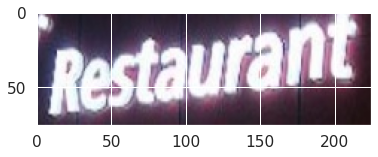

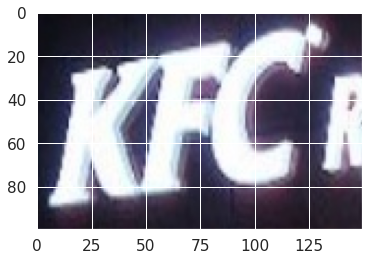

In [ ]:
recognizedText = []
for img in croppedImages:
  saveImg(img)
  recognizedText.append(recognizeText("/content/recognize11.jpg"))

Restaurant
KeFr


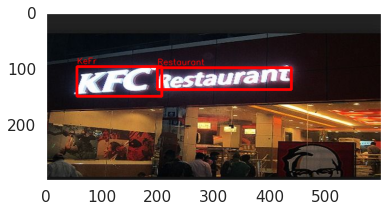

In [ ]:
showRecogImg(path, rectangles, recognizedText)

(1218, 1280, 3)
(512, 512, 3)
[[160.11464881896973, 66.26397819519043, 250.35922813415527, 115.94077568054199], [254.6848922729492, 64.72827129364013, 369.688028717041, 116.1401559829712], [51.78433151245116, 233.54265480041505, 376.03832321166993, 386.4767467498779]]


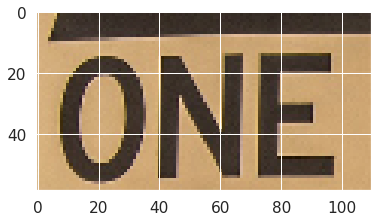

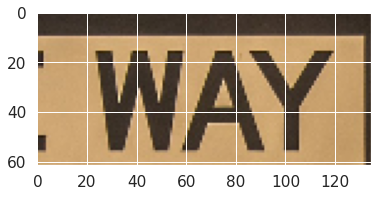

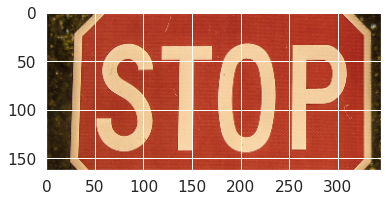

In [ ]:
#img = cv2.imread("/content/Train/"+trainFiles[2])
path = "/content/detect2.jpg"
img = cv2.imread(path)
print(img.shape)
img = cv2.resize(img, (512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
print(img.shape)
img = (img - 127.5)/127.5
croppedImages,rectangles = predict_func(charDetect, np.expand_dims(img,axis= 0), 0.5, "test")

(59, 110)
3
(1, 32, 128, 1)
ONE
(62, 135)
1
(1, 32, 128, 1)
WAY
(163, 345)
1
(1, 32, 128, 1)
Istol


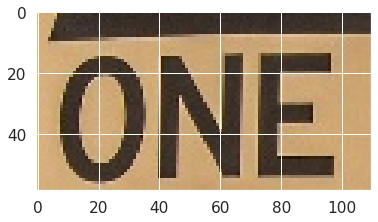

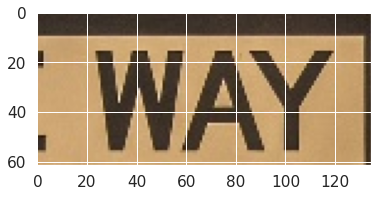

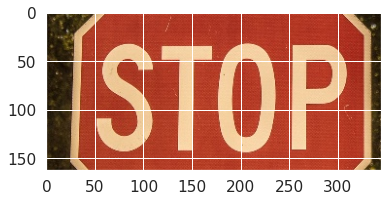

In [ ]:
recognizedText = []
for img in croppedImages:
  saveImg(img)
  recognizedText.append(recognizeText("/content/recognize11.jpg"))

ONE
WAY
Istol


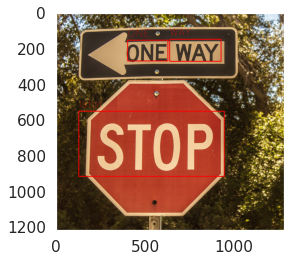

In [ ]:
showRecogImg(path, rectangles, recognizedText)

(388, 400, 3)
(512, 512, 3)
[[119.00045166015624, 237.8557285308838, 295.3577026367187, 292.82566795349123], [107.74890327453613, 290.5823980331421, 183.26771354675293, 328.34529438018797], [83.436279296875, 341.01990776062013, 151.1198501586914, 375.5042297363281], [229.7976749420166, 325.0576454162598, 321.84961051940917, 361.57409515380857], [140.71312618255615, 336.78486795425414, 221.38392734527588, 368.4458764076233], [193.4331932067871, 290.134010887146, 288.8885040283203, 326.67637195587156]]


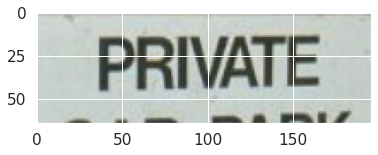

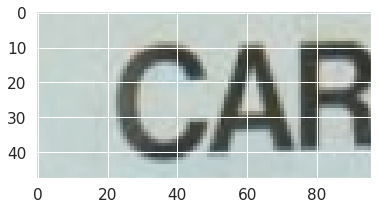

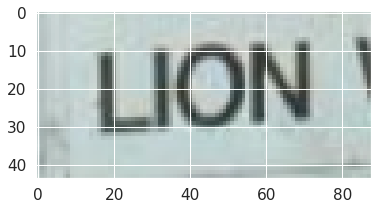

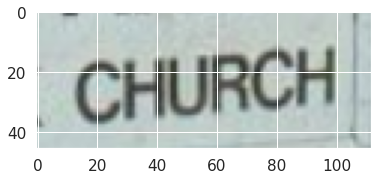

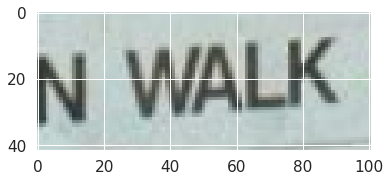

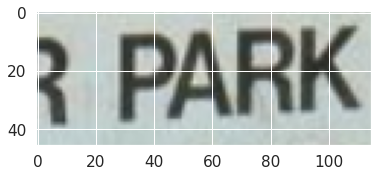

In [ ]:
#img = cv2.imread("/content/Train/"+trainFiles[2])
path = "/content/detect7.jpg"
img = cv2.imread(path)
print(img.shape)
img = cv2.resize(img, (512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
print(img.shape)
img = (img - 127.5)/127.5
croppedImages,rectangles = predict_func(charDetect, np.expand_dims(img,axis= 0), 0.5, "test")

(65, 196)
1
(1, 32, 128, 1)
PPRIVATE
(48, 96)
3
(1, 32, 128, 1)
BE
(44, 88)
3
(1, 32, 128, 1)
LLIONM
(46, 112)
3
(1, 32, 128, 1)
CHURCH
(42, 101)
3
(1, 32, 128, 1)
NWALK
(46, 115)
3
(1, 32, 128, 1)
PPARK


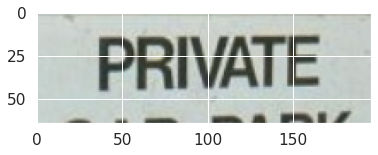

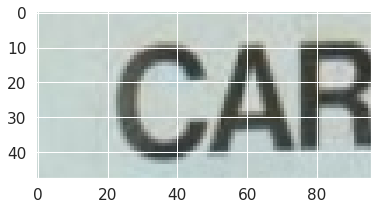

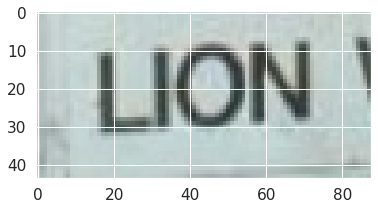

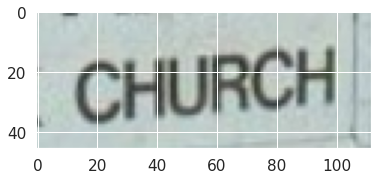

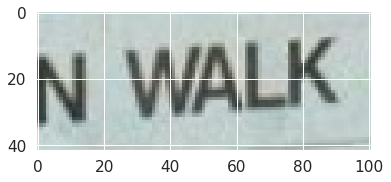

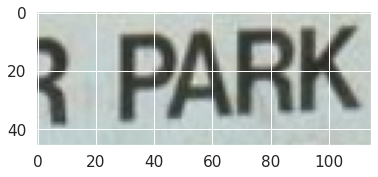

In [ ]:
recognizedText = []
for img in croppedImages:
  saveImg(img)
  recognizedText.append(recognizeText("/content/recognize11.jpg"))

PPRIVATE
BE
LLIONM
CHURCH
NWALK
PPARK


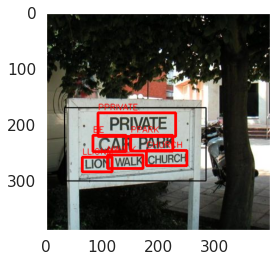

In [ ]:
showRecogImg(path, rectangles, recognizedText)

(3001, 3999, 3)
(512, 512, 3)
[[140.56737632751464, 246.1233642578125, 260.564253616333, 292.0264503479004]]


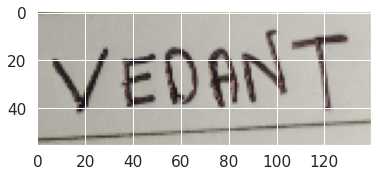

In [ ]:
#img = cv2.imread("/content/Train/"+trainFiles[2])
path = "/content/test8.jpg"
img = cv2.imread(path)
print(img.shape)
img = cv2.resize(img, (512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
print(img.shape)
img = (img - 127.5)/127.5
croppedImages,rectangles = predict_func(charDetect, np.expand_dims(img,axis= 0), 0.5, "test")

(56, 140)
1
(1, 32, 128, 1)
VEDANT


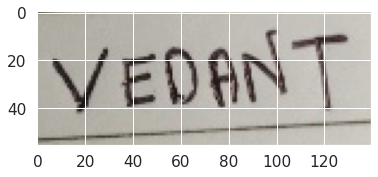

In [ ]:
recognizedText = []
for img in croppedImages:
  saveImg(img)
  recognizedText.append(recognizeText("/content/recognize11.jpg"))

VEDANT


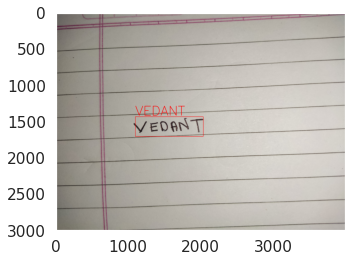

In [ ]:
showRecogImg(path, rectangles, recognizedText)

(720, 1280, 3)
(512, 512, 3)
[[198.33184890747071, 131.40789451599122, 344.4376480102539, 209.9853130340576]]


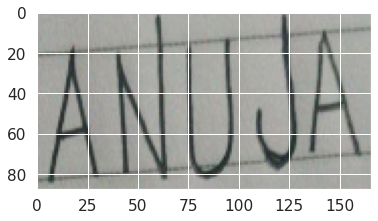

In [ ]:
#img = cv2.imread("/content/Train/"+trainFiles[2])
path = "/content/recognize13.jpeg"
img = cv2.imread(path)
print(img.shape)
img = cv2.resize(img, (512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
print(img.shape)
img = (img - 127.5)/127.5
croppedImages,rectangles = predict_func(charDetect, np.expand_dims(img,axis= 0), 0.5, "test")

(88, 166)
1
(1, 32, 128, 1)
ANUJA


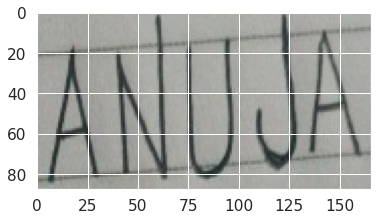

In [ ]:
recognizedText = []
for img in croppedImages:
  saveImg(img)
  recognizedText.append(recognizeText("/content/recognize11.jpg"))

ANUJA


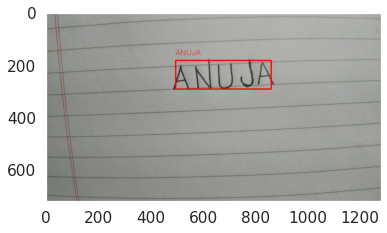

In [ ]:
showRecogImg(path, rectangles, recognizedText)